In [16]:
import yfinance as yf
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from keras._tf_keras.keras.models import Sequential
from keras._tf_keras.keras.layers import LSTM, Dense, Dropout, Input
from keras._tf_keras.keras.regularizers import L2

In [17]:
def format_data(stock):
    stock_chosen = yf.Ticker(f"{stock}")
    stock_data = stock_chosen.history(start='2010-01-01', end='2024-09-01', interval="1d")
    
    stock_data.dropna(inplace=True)
    sp500_data = yf.download("^GSPC", start='2010-01-01', end='2024-09-01', interval="1d")
    sp500_data = sp500_data['Close'].rename('S&P500_Close')
    stock_data.index = stock_data.index.tz_localize(None)
    sp500_data.index = sp500_data.index.tz_localize(None)
    stock_data = stock_data.join(sp500_data, how='inner')
    stock_data = stock_data.drop(columns=["Dividends", "Stock Splits", "Volume", "Open"])
    features = ['Close', 'S&P500_Close']
    stock_data = stock_data[features].dropna()
    
    stock_data['Target'] = stock_data['Close'].shift(-1)
    stock_data.dropna(inplace=True)
    print(stock_data.columns)
    return stock_data

In [18]:
stock_data = format_data("AAPL")

[*********************100%***********************]  1 of 1 completed

Index(['Close', 'S&P500_Close', 'Target'], dtype='object')


In [19]:
features = ['Close', 'S&P500_Close']
X = stock_data[features]
Y = stock_data['Target']

print(X.head())
print(Y.head())

               Close  S&P500_Close
Date                              
2010-01-04  6.454504   1132.989990
2010-01-05  6.465664   1136.520020
2010-01-06  6.362819   1137.140015
2010-01-07  6.351056   1141.689941
2010-01-08  6.393281   1144.979980
Date
2010-01-04    6.465664
2010-01-05    6.362819
2010-01-06    6.351056
2010-01-07    6.393281
2010-01-08    6.336884
Name: Target, dtype: float64


In [31]:
# def create_train_test(stock_data, features, test_size=0.2):
#     X = stock_data[features]
#     Y = stock_data['Target']
    
#     # Separate test set
    
#     X_training_set, X_testing_set, Y_training_set, Y_testing_set = train_test_split(stock_data, features, test_size=test_size)
    
#     return X_training_set, X_testing_set, Y_training_set, Y_testing_set


# X_training_set, X_testing_set, Y_training_set, Y_testing_set = create_train_test(stock_data, features)

X_training_set, X_testing_set, Y_training_set, Y_testing_set = train_test_split(X, Y, test_size=0.2, shuffle=False)

print(X_training_set.head())
print(X_testing_set.head())
print(Y_training_set.head()) 
print(Y_testing_set.head())


               Close  S&P500_Close
Date                              
2010-01-04  6.454504   1132.989990
2010-01-05  6.465664   1136.520020
2010-01-06  6.362819   1137.140015
2010-01-07  6.351056   1141.689941
2010-01-08  6.393281   1144.979980
                 Close  S&P500_Close
Date                                
2021-09-23  144.411774   4448.979980
2021-09-24  144.500275   4455.479980
2021-09-27  142.975784   4443.109863
2021-09-28  139.572800   4352.629883
2021-09-29  140.477646   4359.459961
Date
2010-01-04    6.465664
2010-01-05    6.362819
2010-01-06    6.351056
2010-01-07    6.393281
2010-01-08    6.336884
Name: Target, dtype: float64
Date
2021-09-23    144.500275
2021-09-24    142.975784
2021-09-27    139.572800
2021-09-28    140.477646
2021-09-29    139.169556
Name: Target, dtype: float64


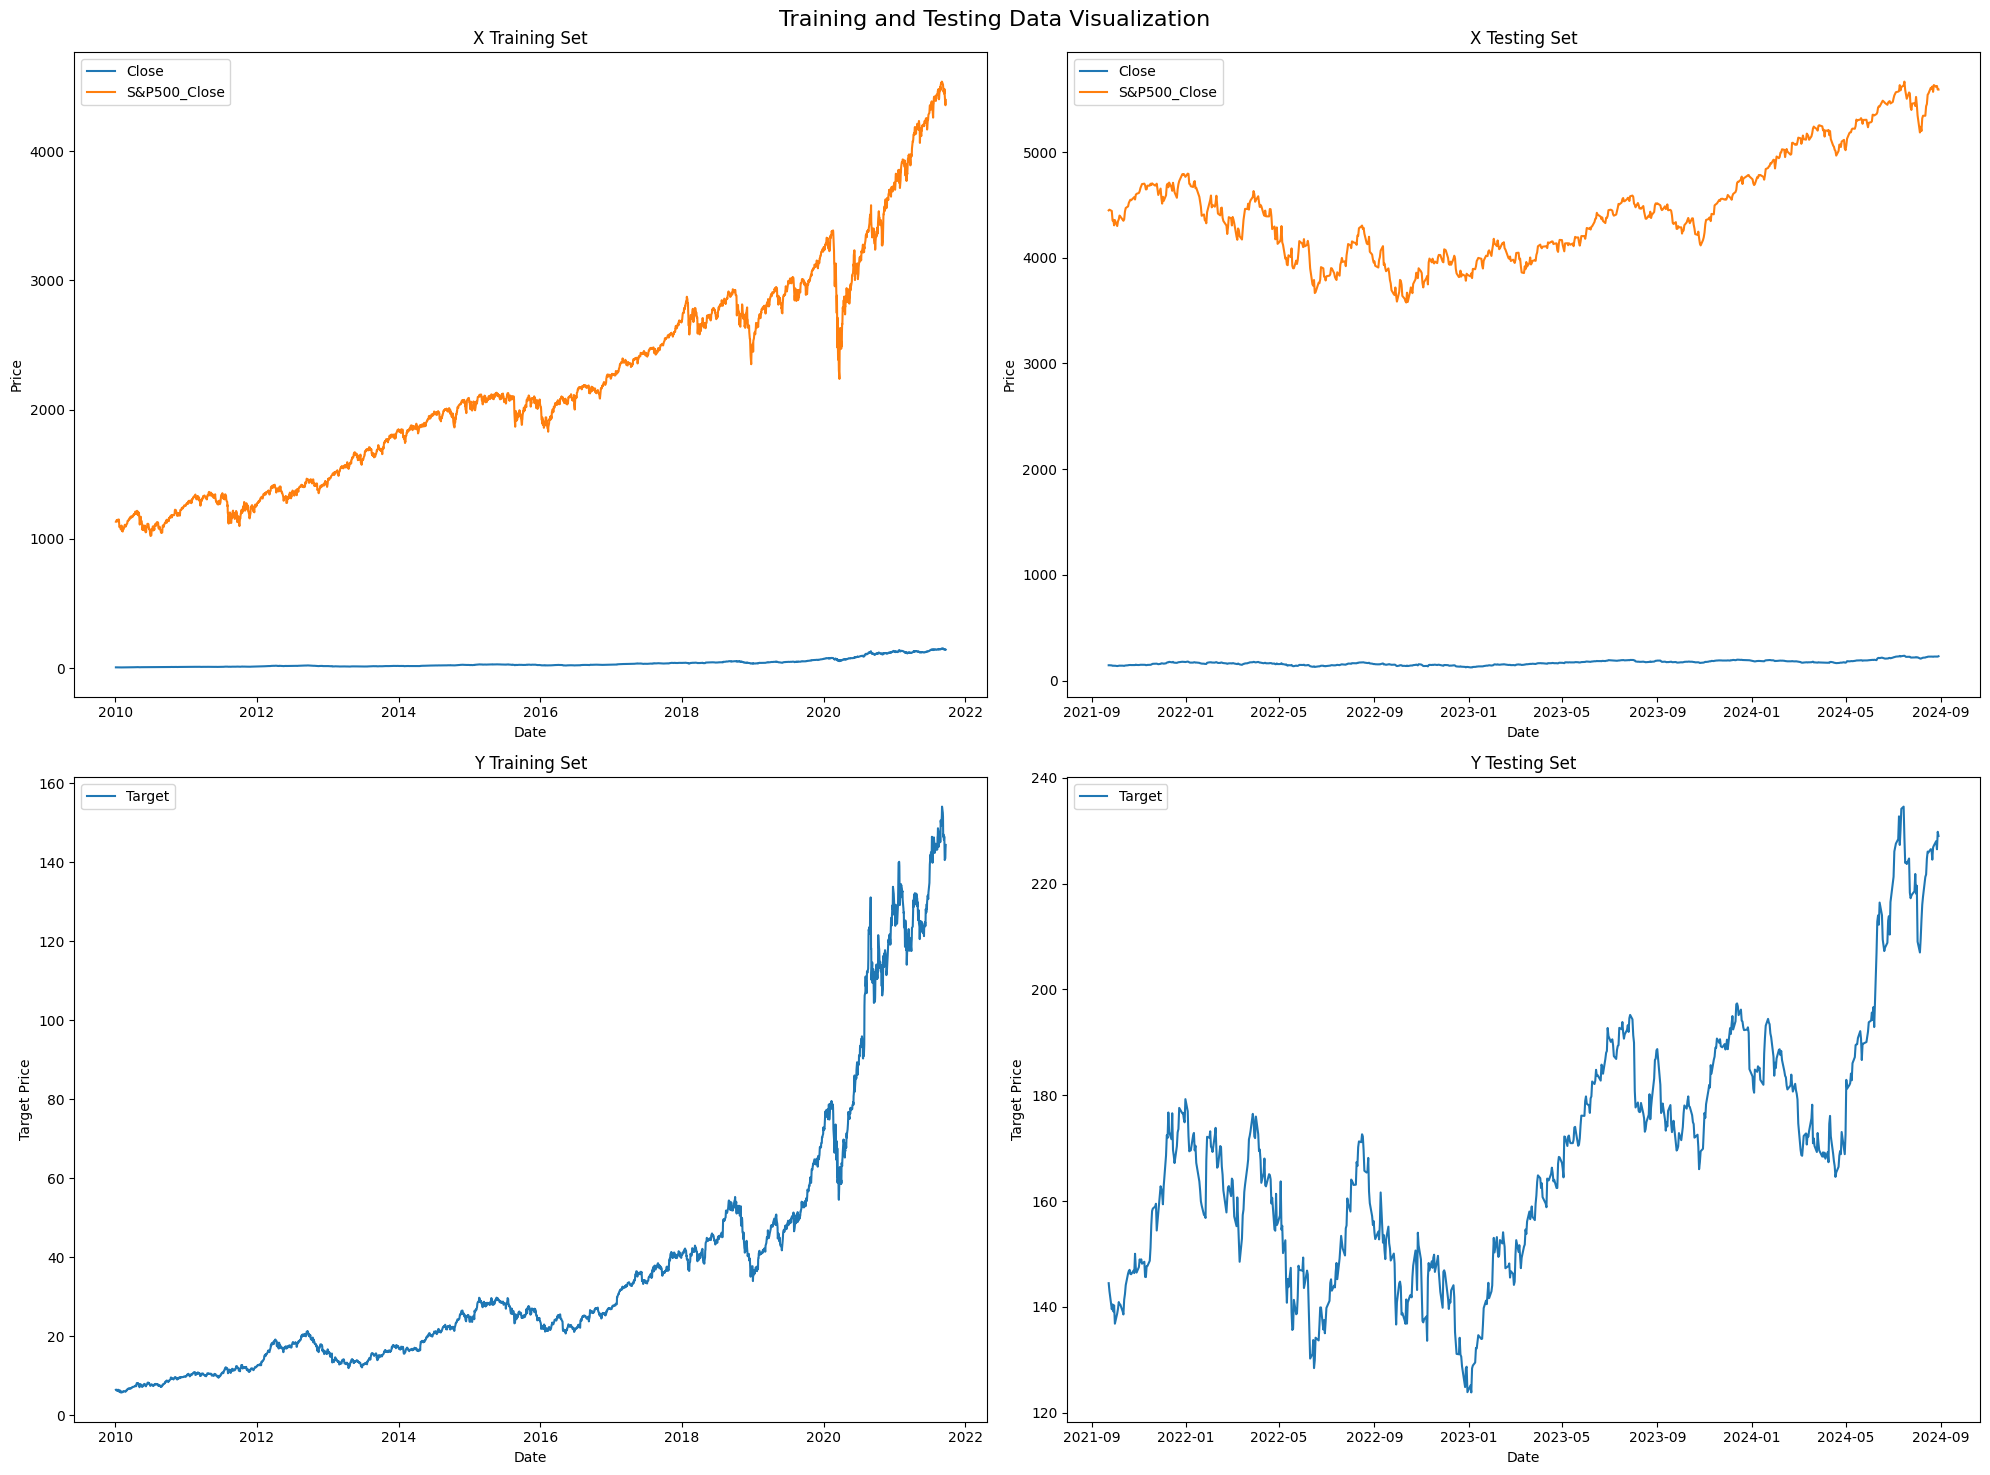

In [32]:
fig, axs = plt.subplots(2, 2, figsize=(20, 15))
fig.suptitle('Training and Testing Data Visualization', fontsize=16)

# Plot X_training_set
axs[0, 0].plot(X_training_set['Close'], label='Close')
axs[0, 0].plot(X_training_set['S&P500_Close'], label='S&P500_Close')
axs[0, 0].set_title('X Training Set')
axs[0, 0].legend()
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('Price')

# Plot X_testing_set
axs[0, 1].plot(X_testing_set['Close'], label='Close')
axs[0, 1].plot(X_testing_set['S&P500_Close'], label='S&P500_Close')
axs[0, 1].set_title('X Testing Set')
axs[0, 1].legend()
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('Price')

# Plot Y_training_set
axs[1, 0].plot(Y_training_set, label='Target')
axs[1, 0].set_title('Y Training Set')
axs[1, 0].legend()
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('Target Price')

# Plot Y_testing_set
axs[1, 1].plot(Y_testing_set, label='Target')
axs[1, 1].set_title('Y Testing Set')
axs[1, 1].legend()
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('Target Price')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [33]:
scaler = MinMaxScaler(feature_range=(0, 1))

X_training_scaled = scaler.fit_transform(X_training_set)
Y_training_scaled = scaler.fit_transform(Y_training_set.values.reshape(-1, 1))

X_testing_scaled = scaler.fit_transform(X_testing_set)
Y_testing_scaled = scaler.fit_transform(Y_testing_set.values.reshape(-1, 1))

print(X_training_scaled.shape)
print(Y_training_scaled.shape)
print(X_testing_scaled.shape)
print(Y_testing_scaled.shape)
    


(2951, 2)
(2951, 1)
(738, 2)
(738, 1)


In [35]:
def create_sequences(X_data, Y_data, sequence_length=60):
    Xs, Ys = [], []
    for i in range(len(X_data) - sequence_length):
        Xs.append(X_data[i:(i + sequence_length)])
        Ys.append(Y_data[i + sequence_length])
    return np.array(Xs), np.array(Ys)

window_size = 60
features_no = 2 


X_training_seq, Y_training_seq = create_sequences(X_training_scaled, Y_training_scaled, window_size)  

X_testing_seq, Y_testing_seq = create_sequences(X_testing_scaled, Y_testing_scaled, window_size)

X_train = X_training_seq
X_test = X_testing_seq
Y_train = Y_training_seq
Y_test = Y_testing_seq

print(X_testing_seq.shape, Y_testing_seq.shape)
print(X_training_seq.shape, Y_training_seq.shape)
print(X_train.shape)
print(X_test.shape)


(678, 60, 2) (678, 1)
(2891, 60, 2) (2891, 1)
(2891, 60, 2)
(678, 60, 2)


In [36]:
def createModel(input_shape):
    model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    return model


input_shape = (X_train.shape[1], X_train.shape[2])
model = createModel(input_shape)

predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

Y_test = scaler.inverse_transform(Y_testing_seq)


model.compile(optimizer='adam', loss='mse')

history = model.fit(
    X_train, Y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2
)

/Users/danielliao/git/stock-prediction-model/env/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0105 - val_loss: 0.0739
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 7.4579e-04 - val_loss: 0.0337
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 4.6850e-04 - val_loss: 0.0320
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 3.7202e-04 - val_loss: 0.0297
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 3.8814e-04 - val_loss: 0.0149
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 2.6301e-04 - val_loss: 0.0133
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 2.8228e-04 - val_loss: 0.0141
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 2.3800e-04 - val_loss: 0.0250
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 2.2351e-04 - val_loss: 0.0202
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 1.8024e-04 - val_loss: 0.0184
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 1.9341e-04 - 

In [37]:
lstm_stock_pred = model.predict(X_test)
lstm_stock_pred = scaler.inverse_transform(lstm_stock_pred)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [38]:
def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))
    
return_rmse(Y_test, lstm_stock_pred)

The root mean squared error is 8.33.


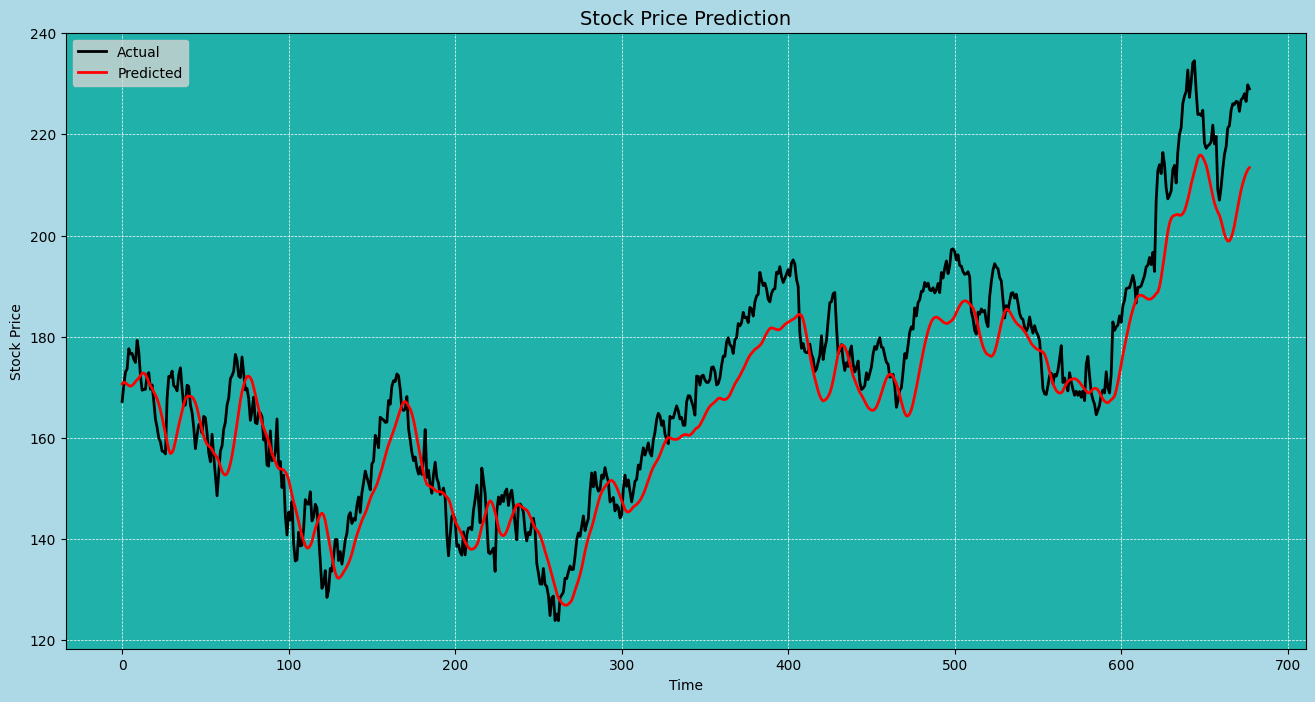

In [40]:
def plot_predictions(test, predicted):
    import matplotlib.pyplot as plt

    
    fig = plt.figure(figsize=(16, 8), facecolor='lightblue')
    
    ax = fig.add_subplot(111)
    ax.set_facecolor('lightseagreen')
    ax.plot(test, color='black', linewidth=2, label="Actual")
    ax.plot(predicted, color='red', linewidth=2, label="Predicted")
    leg = plt.legend(facecolor='lightgrey')

    for text in leg.get_texts():
        text.set_color('black')

    plt.title("Stock Price Prediction", color='black', fontsize=14)
    plt.xlabel("Time", color='black', fontsize=10)
    plt.ylabel("Stock Price", color='black', fontsize=10)
    ax.grid(True, color='white', linestyle='--', linewidth=0.5)

    # Show the plot
plt.show()



def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))


    
plot_predictions(Y_test,lstm_stock_pred)